# Impact function calibration
#### calibrating an impact function which relates the gridded crowdsourced hail size to expected relative impacts (Percent of Assets Affected & Mean Damage Ratio)

In [1]:
#Load pacakges
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as PathEffects
import datetime as dt
from matplotlib.colors import BoundaryNorm

from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.engine import ImpactCalc
from climada.hazard import Hazard
from climada import CONFIG
import scClim as sc
from scClim.constants import CUT_OFF_DICT, UNIT_DICT,INT_RANGE_DICT,INT_LABEL_DICT,ID_COL_DICT,W_SIZE_DICT,DMG_BIN_DICT

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)


In [2]:
# Define parameters

haz_var = 'crowd'
exp_var = 'KGV' # Exposure='Kantonale Gebäudeversicherungen'
version= 27     # Gridding version 2.7

#Define of considered years
years = np.arange(2020,2023+1)
n_years = len(years)

#Read unit, intensity range and cut-off
unit = UNIT_DICT[haz_var]
intensity_range=INT_RANGE_DICT[haz_var]
intensity_label = INT_LABEL_DICT[haz_var]
cut_off = CUT_OFF_DICT[haz_var]
cut_off_overwrite = None

#cut_off value can be overwritten here
#TODO: use only this in final version
if version in [9,12,121,13,15,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,    40,41]:
    cut_off = 68
    cut_off_overwrite = 68



#Define windowsize to calculate running mean (in hazard units):
assert(len(np.unique(np.diff(intensity_range[1:])))==1)
stepsize = np.unique(np.diff(intensity_range[1:]))[0]
window_size = W_SIZE_DICT[haz_var]
unit_windowsize = stepsize*window_size
dmg_bin_size=DMG_BIN_DICT[haz_var]
#xlim for plots
xlim = [min(intensity_range)-2, max(intensity_range)]

#print all parametrs
print(f"cut_off: {cut_off}, intensity_range: {intensity_range[0]}-{intensity_range[-1]}, "
      f"window_size: {window_size}, dmg_bin_size: {dmg_bin_size}, unit: {unit}, "
      f"unit_windowsize: {unit_windowsize}, xlim: {xlim}")


cut_off: 68, intensity_range: 0-69, window_size: 10, dmg_bin_size: 5, unit: mm, unit_windowsize: 10, xlim: [-2, 69]


c:\Users\timschmi\miniforge3\envs\climada_3_3\lib\pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


<GeoAxes: title={'center': 'HL max intensity at each point'}>

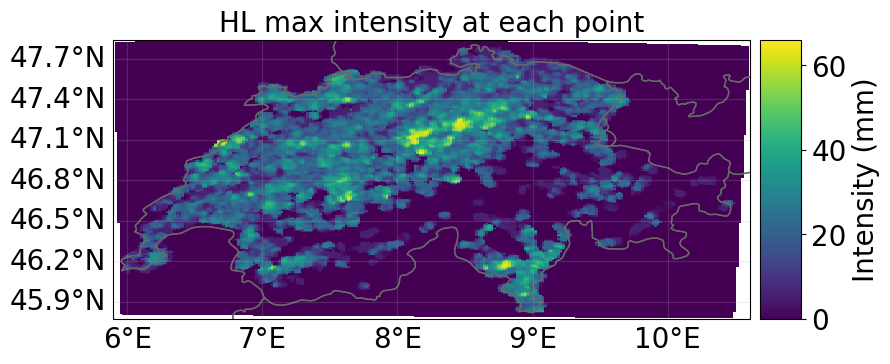

In [3]:
#Load hazard
haz = Hazard.from_hdf5(f'{data_dir}/crowd-source/hazard_min25_2020+_V{version}.h5')
haz.plot_intensity(0)

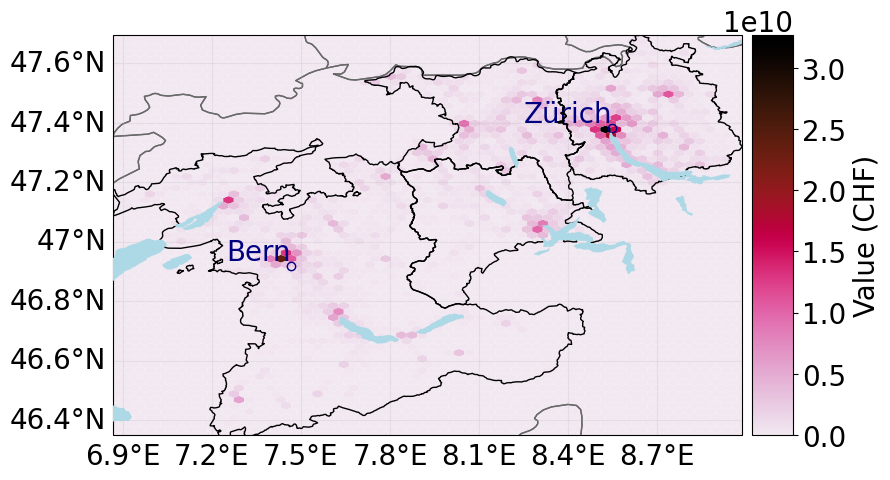

In [4]:
#Load exposure (Data from 4 cantonal building insurances)
exp = sc.read_gvz_exposure(f'{data_dir}/{exp_var}/Gebäudewert_geocoded_v3.csv',
                            crs = 'EPSG:4326')
exp.assign_centroids(haz)
exp.gdf=exp.gdf.rename(columns={ID_COL_DICT[exp_var]:'VersicherungsID'})

#Plot data
ax = exp.plot_hexbin(gridsize=60,linewidths=0,vmin=0)
sc.plot_canton(ax,canton=['Zürich','Bern','Luzern','Aargau'],zorder=5)

<GeoAxes: title={'center': 'Expected annual impact'}>

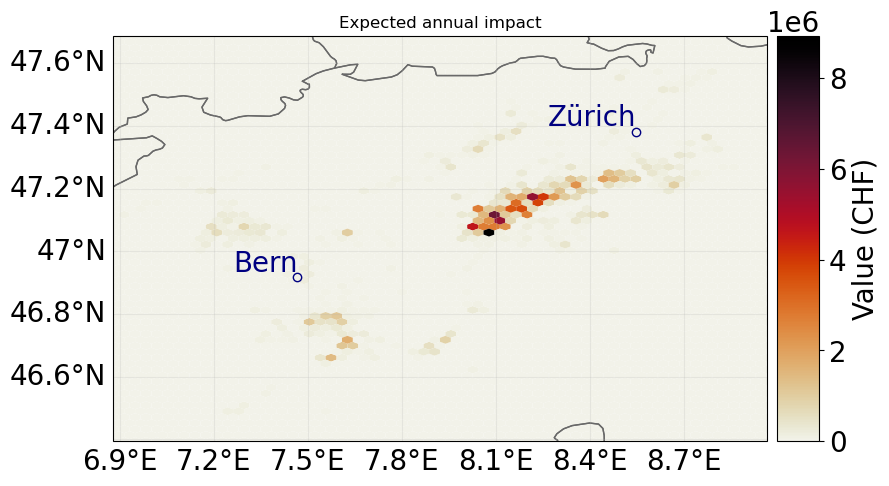

In [5]:
#Load impact data
index_dmgs = False #KGV exposure is already indexed to year 2021

imp_path = (f"{data_dir}/{exp_var}/{exp_var}_Hail_Loss_date_corrected71.csv") #V7.1 contains data up to 2023
imp_measured = sc.read_gvz_dmg(imp_path, exp_var,return_type='imp',
                                years=(years[0],years[-1]),
                                baujahr_filter="",index_dmgs=index_dmgs,
                                crs='EPSG:4326',id_col=ID_COL_DICT[exp_var])

#Select only data where crowdsourced hazard exists (Aug 2020 - Sept 2023)
#and during the hail season (Apr-Sept)
month= np.array([dt.datetime.fromordinal(d).month for d in imp_measured.date])
year = np.array([dt.datetime.fromordinal(d).year for d in imp_measured.date])
event_ids= imp_measured.event_id[((month>=4) & (month<=9)) & ~((month<=7) & (year==2020))]
imp_measured = imp_measured.select(event_ids=event_ids)

#Plot the avarage annual impact
imp_measured.plot_hexbin_eai_exposure(gridsize=60,linewidths=0,vmin=0)

### Prepare calibration

In [6]:
# create idendity impact function (for selcetion of dates with nonzero
# hazard intensity over an exposed asset)
imp_fun_set = ImpactFuncSet()
imp_fun_identity = ImpactFunc.from_step_impf((0, 1, max(intensity_range)*2),haz_type='HL')
imp_fun_set.append(imp_fun_identity)
# calculate impact (with identitiy impact function) and define dates with nonzero impact
imp = ImpactCalc(exp, imp_fun_set, haz).impact(save_mat=True)
dates_modeled_imp = np.array([dt.datetime.fromordinal(d) for d in imp.date[imp.at_event > 0]])


if any([imp_date not in haz.date for imp_date in imp_measured.date]):
    print('Some dates with measured impact, are not contained in the '
          'Hazard file. Intensity=0 is assumed for these events')

    #identify dates with damages, but no hazard info
    dates = imp_measured.date[np.array([imp_date not in haz.date for imp_date
                                        in imp_measured.date])]
    print(f"{len(dates)} dates with damages, but no hazard info")
    #set hazard intensity to zero at these dates
    haz2 = sc.calibration.extend_haz(haz,dates)
    haz=haz2


Some dates with measured impact, are not contained in the Hazard file. Intensity=0 is assumed for these events
35 dates with damages, but no hazard info


In [7]:
# run calibration (as in Schmid et al., (2024))
calib_tuple = sc.empirical_calibration_per_exposure(hazard_object = haz,
    exposure_object = exp, damages = imp_measured, exposure_type = 'GVZ',
    variable = haz_var,filter_year=None,dates_modeled_imp=dates_modeled_imp,
    roll_window_size=window_size,get_PVA=True,cut_off_overwrite=cut_off_overwrite)
ds, df_all, ds_roll, ds_roll_cut, values_at_centroid_all, intensity_range = calib_tuple

#make sure zero values for PAA,MDR are included (not NaN)
values_at_centroid_all['PAA'] = (values_at_centroid_all['n_dmgs']/
                                 values_at_centroid_all['n_exp'])
values_at_centroid_all['MDR'] = (values_at_centroid_all['dmg_val']/
                                 values_at_centroid_all['exp_val'])


2025-05-02 14:39:12,202 - climada.util.coordinates - WARNING - This function has been renamed, use match_coordinates instead.


In [8]:
#Create bootstrapping samples
n_samples=100
out_tuple=sc.bootstrapping(ds, ds_roll,haz_var,n_samples,intensity_range,
                           log_fit=False,cut_off=cut_off,keep_raw_values=True)
ds_boot,ds_boot_roll,ds_boot_roll_cut, fit_data = out_tuple

Optimization terminated successfully.
         Current function value: 0.000089
         Iterations: 396
         Function evaluations: 680
{'v_thresh': 5.812153169343389e-07, 'v_half': 75.8298962408077, 'scale': 0.05378509254221708, 'power': 6.3131853642027025}
Equiv. impact bias: -0.000%


c:\users\timschmi\documents\phd\code\scclim\scClim\calib_opt.py:814: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(mse_x, x0,


{'v_thresh': 0.0, 'v_half': 69.70828316771531, 'scale': 0.9999999999782767, 'power': 3.967344305360953}
Equiv. impact bias: -6.545%
Optimization terminated successfully.
         Current function value: 0.077405
         Iterations: 76
         Function evaluations: 135
{'v_thresh': 0.0, 'v_half': 138.0, 'scale': 0.16011139976244448, 'power': 2.167241782589256}
Equiv. impact bias: -86.941%


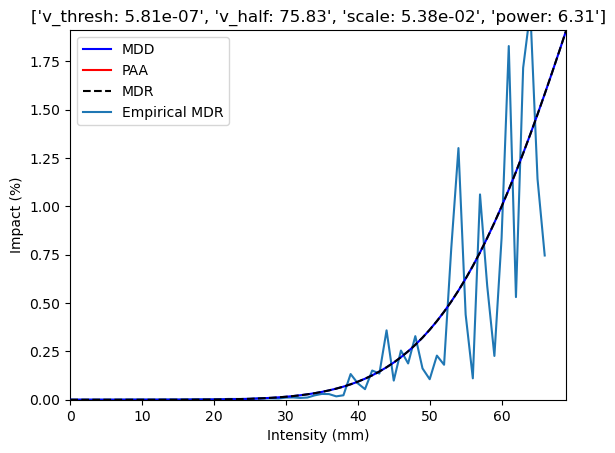

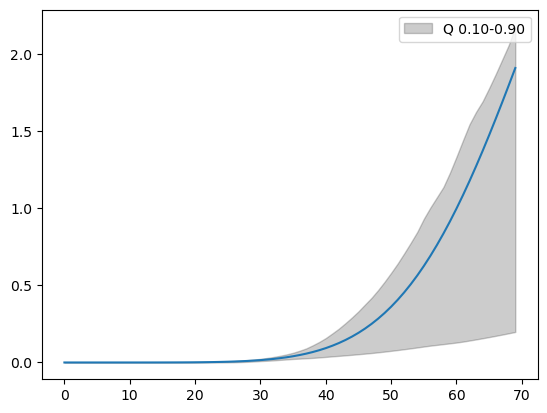

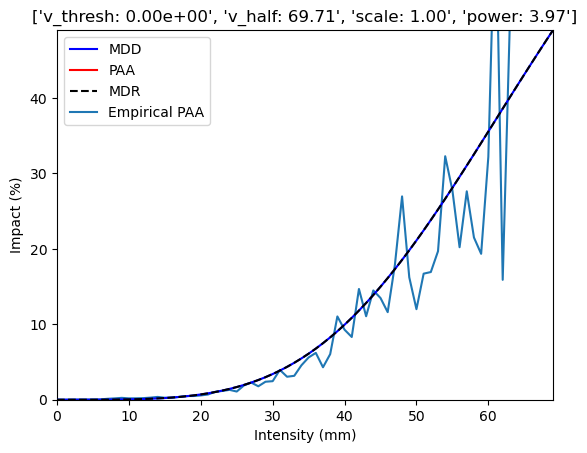

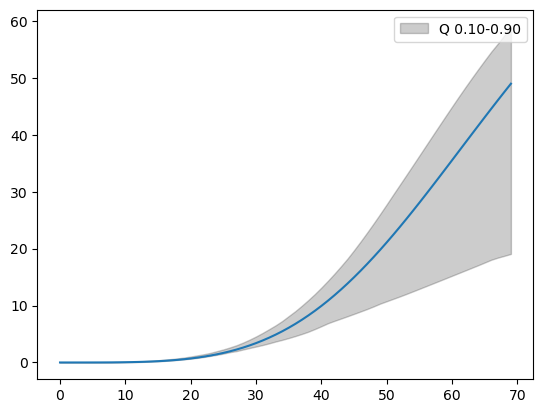

In [9]:
#Fit sigmoidal functions
df, df_roll, df_roll_cut, n_dmgs = sc.compute_empirical_damage_functions(ds,ds_roll,
                                                                         ds_roll_cut,
                                                                         get_monotonic_fit=False)


fit_type = "flex_noBias"
if fit_type == "": #fixed to exponent=3
    kwargs = {}
    power= (3,3)
elif fit_type == "flex": #flexible exponent
    kwargs = {}
    power = (2,10)
elif fit_type == "flex_noBias": #flexible exponent, and minimizing absolute bias
    kwargs = {'bias_weight': 1}
    power = (2,10)


# fit Sigmoidal function
v_tresh_bounds = [min(intensity_range),max(intensity_range)]
# hardcode higher v_half threshold for faster convergence (still far below actual value)
v_half_bounds = [10,max(intensity_range)*2]
pbounds={'v_thresh': v_tresh_bounds, 'v_half': v_half_bounds,
         'scale': [df.MDR.max()/10, min(1,df.MDR.max()*10)],
          'power': power
          }

# Starting parameters for the optimization
# (vthresh: first value > 1% of 'scale', v_half: first value >0.5*scale)
param_start = {'v_thresh':df_roll.index[df_roll.MDR>(df_roll.MDR.max()/100)].values[0],
                'v_half': df_roll.index[df_roll.MDR>(df_roll.MDR.max()/2)].values[0],
                'scale':df_roll.MDR.max(),'power':3}

p,res,impf_emanuelMDR = sc.calib_opt.fit_emanuel_impf_to_emp_data(
    df,pbounds,param_start=param_start,**kwargs
    )


# Emanuel fit for every bootstrapped sample
df_boot_emanuel,df_boot_params = sc.calib_opt.fit_emanuel_to_bootstrap(
    ds_boot,impf_emanuelMDR,pbounds,opt_var='MDR',plot='quant',param_start=param_start,**kwargs)

# Fit PAA
pboundsPAA={'v_thresh': v_tresh_bounds, 'v_half': v_half_bounds,
            'scale': [df_roll.PAA.max()/10, min(1,df.PAA.max()*10)],
                      'power' : power}

param_start_PAA = {'v_thresh':df_roll.index[df_roll.PAA>(df_roll.PAA.max()/100)].values[0], # first value > 1% of 'scale'
                   'v_half': df_roll.index[df_roll.PAA>(df_roll.PAA.max()/2)].values[0], #first value >0.5*scale
                   'scale':df_roll.PAA.max(),'power':3}

p_PAA,resPAA,impf_emanuelPAA = sc.calib_opt.fit_emanuel_impf_to_emp_data(
    df,pboundsPAA,param_start=param_start_PAA,opt_var='PAA',**kwargs
    )

# bootstrap samples
df_boot_emanuel_PAA, df_boot_paramsPAA = sc.calib_opt.fit_emanuel_to_bootstrap(
    ds_boot,impf_emanuelPAA,pboundsPAA,opt_var='PAA',plot='quant',
    param_start=param_start_PAA,**kwargs)

# Fit MDD
df_roll.loc[df_roll.MDD==np.inf,'MDD']=np.nan
pboundsMDD={'v_thresh': v_tresh_bounds, 'v_half': v_half_bounds,
            'scale': [df.MDD.max()/10, df.MDD.max()*5],
            'power': power}
p_MDD,resMDD,impf_emanuelMDD = sc.calib_opt.fit_emanuel_impf_to_emp_data(
    df_roll,pboundsMDD,opt_var='MDD',plot=False,**kwargs
    )

### Plot impact functions

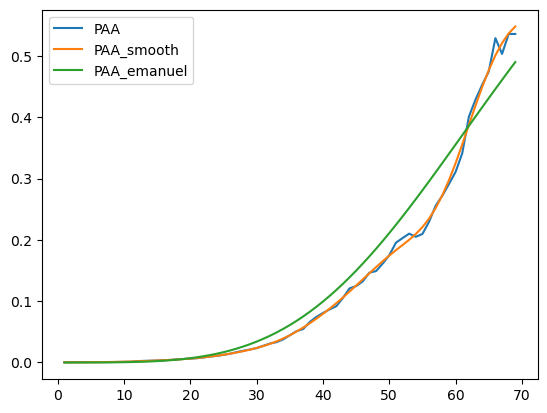

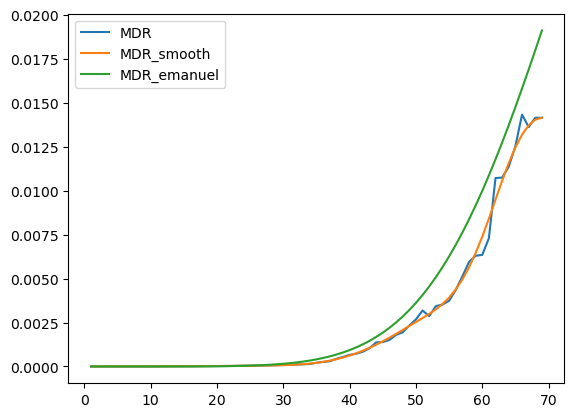

In [11]:
#save impact functions to csv
intensity = intensity_range

df_impf = pd.DataFrame(index=intensity, columns=['PAA', 'MDD', 'MDR'])
for var in ['PAA', 'MDD', 'MDR']:
    df_impf.loc[1:, var] = df_roll[var].loc[intensity_range[1:]]

    # add smoothed function
    # df_roll_cut.apply(sc.)
    smooth = sc.smooth_monotonic(
        df_roll_cut.index[1:], df_roll_cut[var].loc[intensity_range[1:]])
    # plt.plot(df_roll_cut.index[1:],smooth)

    df_impf.loc[intensity_range[1]:, var+'_smooth'] = smooth

#add Sigmoidal function fit
np.testing.assert_array_equal(impf_emanuelPAA.intensity,intensity_range)
df_impf.loc[intensity_range[1:], 'PAA_emanuel'] = impf_emanuelPAA.mdd[1:]
df_impf.loc[intensity_range[1:], 'MDR_emanuel'] = impf_emanuelMDR.mdd[1:]
df_impf.loc[intensity_range[1:], 'MDD_emanuel'] = impf_emanuelMDD.mdd[1:]

# set values above cut_off to values at cut_off
cut_vars = ['PAA', 'MDR','MDD'] #'MDD'
if haz_var == 'MESHS':  # cut off at 59 instead of 60 for smoother values
    df_impf.loc[cut_off-1:,
                cut_vars] = df_impf.loc[cut_off-1, cut_vars].values
elif haz_var != 'POH': # for POH there is no cut off!
    df_impf.loc[cut_off:, cut_vars] = df_impf.loc[cut_off, cut_vars].values

for var in ['PAA','MDR']:
    df_impf[[var,f'{var}_smooth',f'{var}_emanuel']].plot()

#Save impact function data as .csv file
df_impf.fillna(0).to_csv(f'{data_dir}/out_files/paa_mdd_smooth_KGVcrowdTEMP{fit_type}_V{version}.csv')


### Plot imppact function with scatter plot

In [12]:
#Load building damage data
ds_KGV = xr.open_dataset(data_dir+'/KGV/ds_building_dmg_v71_1000m.nc')
ds_KGV = ds_KGV.rename({'value':'imp_observed'})
ds_KGV['PAA'] = ds_KGV['PAA'].clip(0,1) #very few erroneous entries with >0

#Load crowdsourced data (gridded)
ds=xr.open_dataset(f'{data_dir}/crowd-source/Reports_min25_2020+_V{version}.nc')
ds = ds.rename({'time':'date'})

#Merge datasets
ds_all = xr.merge([ds_KGV,ds.drop_vars(['lat','lon'])],join='right')
ds_all

<xarray.Dataset>
Dimensions:                          (date: 169, chy: 226, chx: 354)
Coordinates:
  * date                             (date) datetime64[ns] 2020-08-01 ... 202...
  * chy                              (chy) int32 1073500 1074500 ... 1298500
  * chx                              (chx) int32 2484500 2485500 ... 2837500
    lon                              (chy, chx) float64 nan nan nan ... nan nan
    lat                              (chy, chx) float64 nan nan nan ... nan nan
Data variables: (12/15)
    imp_observed                     (date, chy, chx) float64 nan nan ... nan
    Versicherungssumme               (date, chy, chx) float64 nan nan ... nan
    n_count                          (date, chy, chx) float64 nan nan ... nan
    PAA                              (date, chy, chx) float64 nan nan ... nan
    MDR                              (date, chy, chx) float64 nan nan ... nan
    n_count_exposure                 (chy, chx) float64 nan nan nan ... nan nan
    ...                               ...
    n_rep                            (date, chy, chx) float64 ...
    pop                              (date, chy, chx) float64 ...
    h_smooth                         (date, chy, chx) float64 ...
    n_rep_within_kernel              (date, chy, chx) float64 ...
    rep_density_within_kernel        (date, chy, chx) float64 ...
    rep_density_within_kernel_weigh  (date, chy, chx) float64 ...

In [13]:
#Convert to pandas dataframe
df_per_cell = sc.E.ds_to_df(ds_all,vars=['h_smooth','PAA','MDR','n_count_exposure'])

In [14]:
#Get per gridcell values from calibration and convert to rolling xarray dataset
for i, start in enumerate(intensity_range[1:]):
    now_cond = np.logical_and(values_at_centroid_all[haz_var] >
                                start-np.floor(unit_windowsize/2),
                                values_at_centroid_all[haz_var] <
                                start+np.floor(unit_windowsize/2))
    gc_now = values_at_centroid_all.where(now_cond).dropna(axis=0, how='all')
    ds_temp = gc_now.to_xarray().drop_vars(
        haz_var).expand_dims(dim={haz_var: [start]})
    ds_temp['index'] = np.arange(0, len(gc_now.index))
    if i == 0:
        ds_roll_gc = ds_temp.copy(deep=True)
    else:
        ds_roll_gc = xr.concat([ds_roll_gc, ds_temp], dim=haz_var)

ds_roll_gc_10plus = ds_roll_gc.where(ds_roll_gc.n_exp>10,drop=True)

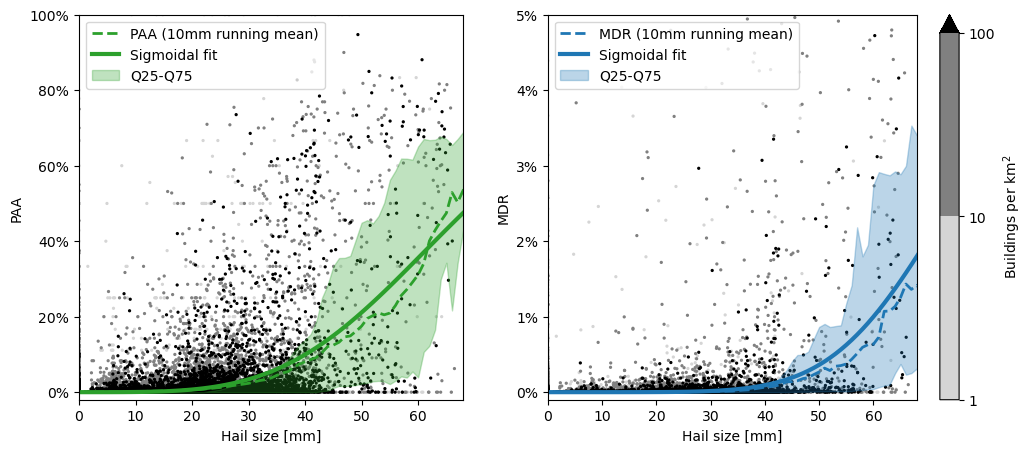

In [15]:
#Plot impact functions
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'width_ratios': [1, 1.2]})
for ax,plot_var,color,ymax,cbar in zip([ax1,ax2],['PAA','MDR'],
                                       ['tab:green','tab:blue'],[1,0.05],
                                       [False,True]):

    ax.plot(df_roll[plot_var],color=color,
            label=f"{plot_var} ({window_size}mm running mean)",lw=2,alpha=1,
            ls='--')
    ax.plot(locals()[f"impf_emanuel{plot_var}"].mdd,color=color,
            label='Sigmoidal fit',lw=3)

    # Create discrete colormap with 5 levels
    # cmap = plt.cm.Greys
    cmap=sc.cut_cmap(plt.cm.Greys,0.25,0.85)
    cmap.set_over('black')
    cmap.set_under('white',alpha=0)
    levels = (1,10,100)#np.linspace(0, 100, 6)  # 6 boundaries gives 5 levels
    norm = BoundaryNorm(levels, cmap.N, extend='max')

    # Create scatter plot without colorbar
    scatter = df_per_cell.sort_values("n_count_exposure").rename(
        columns={"n_count_exposure":"Buildings per km$^2$"}).plot.scatter(
        x='h_smooth',y=plot_var,c="Buildings per km$^2$",cmap=cmap,norm=norm,
        alpha=1,ax=ax,marker='.',s=7,colorbar=cbar)


    q1=0.25;q2=0.75

    ds1 = sc.plot_funcs.get_emp_quantile(ds_roll_gc_10plus, q1)
    ds2 = sc.plot_funcs.get_emp_quantile(ds_roll_gc_10plus, q2)
    ax.fill_between(ds1[haz_var], ds1[plot_var], ds2[plot_var],
                    color=color, alpha=0.3,
                    label='Q%d-Q%d' % (q1*100, q2*100))
    ax.legend(loc = 'upper left')
    ax.set(xlabel='Hail size [mm]', ylabel=plot_var, xlim=(0,68),
            ylim=(-ymax/50,ymax))

    # Format y-axis tick labels as percentages
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

if version == 27:
    fig.savefig(f'{out_dir}/paper_crowd/impf_V3.png', dpi=300,bbox_inches='tight')

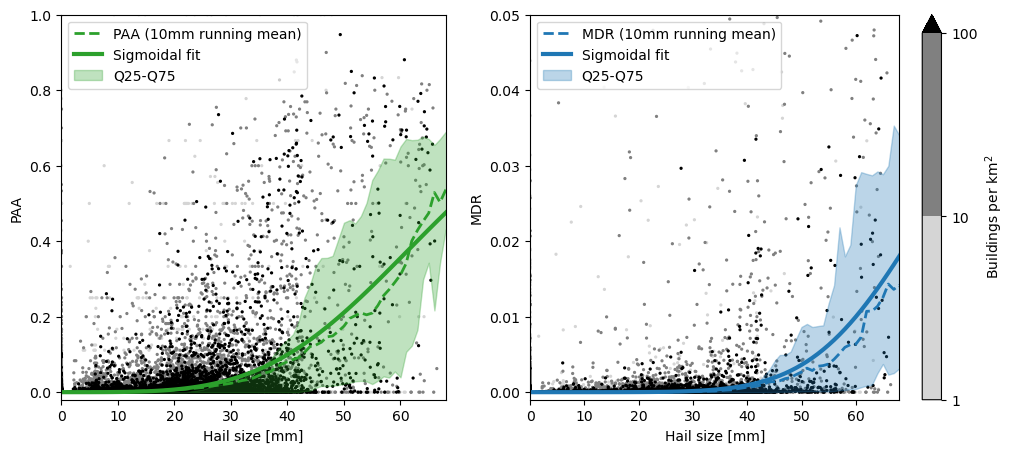

In [ ]:
#V2